# 2025.08.20

## Goals
- [x] Simulate point source test problem (Q volume rate as gaussian, volume as step function)
- [x] Validate Lighthill surface intergral implementation with test problem
- [x] Consider shifting test problem to z = 50 or something to reduce symmetry a little bit
- [ ] Should the stress vector have negative pressure or positive pressure along the diagonal
- [ ] Look into why it is that the dipole term can make contributions of >0 at very early times. 

## 1.0 Test problem
Define a guassian Q volume rate. Volume rate is then a step function. 

$$ 
\begin{align}
p(r, t) &= \frac{\rho \dot{Q}(t-r/c)}{4 \pi r} \\
v_r(r, t) &= \frac{Q(t-\frac{r}{c})}{4 \pi r^2} + \frac{\dot{Q}(t - \frac{r}{c})}{ 4 \pi r c}
\end{align}
$$


For our test problem, let's define Q like:

$$
\begin{align}
Q(t) &= \frac{1}{\sigma \sqrt(2 \pi)} e^{-\frac{1}{2} (\frac{t - \mu}{\sigma})^2} \\
\dot{Q}(t) &= - \frac{t-\mu}{\sigma^2} Q(t)
\end{align}
$$


Below I defined $\sigma = 0.1$ and $\mu=3$. The small variance was selected to guarantee that the impulse was reasonably narrow, and $\mu$ was selected to give the system a second a steady state before introducing the volume perterbation. 

In [101]:
%load_ext autoreload
%autoreload 2

from helper_code.slip_imports import *
from helper_code.helper_functions import get_local_solver_from_index_func

import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import matplotlib
from IPython.display import HTML

matplotlib.rcParams['animation.ffmpeg_path'] = "/opt/homebrew/bin/ffmpeg"

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [146]:
import numpy as np 

RHO_0 = 10
SIGMA = 0.1
MU = 3

def Q(t, sigma=SIGMA, mu=MU, magnitude=1e2):
    return magnitude / (sigma * np.sqrt(2 * np.pi)) * np.exp(-0.5 * (t - mu)**2 / sigma)

def Q_dot(t, sigma=SIGMA, mu=MU):
    return - (t - mu) /sigma**2 *  Q(t, sigma)

def test_pressure(t, r, z, c=300, rho_0=RHO_0, z0=0):
    r_spherical = np.linalg.norm([r, z - z0])

    return rho_0 * Q_dot(t - r_spherical/c) / (4 * np.pi * r_spherical)

def test_sigma(t, r, z, c=300, rho_0=RHO_0, z0=0):
    return np.eye(3) * test_pressure(t, r, z, c, rho_0, z0=z0)

def test_velocity(t, r, z, c=300, z0=0):
    r_spherical = np.linalg.norm([r, z - z0])
    
    v_radial = Q(t - r_spherical/c) / (4 * np.pi * r_spherical**2) + Q_dot(t - r_spherical/c) / (4 * np.pi * r_spherical * c)

    norm_rz = np.array([r, z])/np.linalg.norm([r,z])

    if np.isscalar(v_radial):
        return v_radial * norm_rz
    else:
        return v_radial[:, np.newaxis] * norm_rz

def test_rho(t, r, z):
    return RHO_0

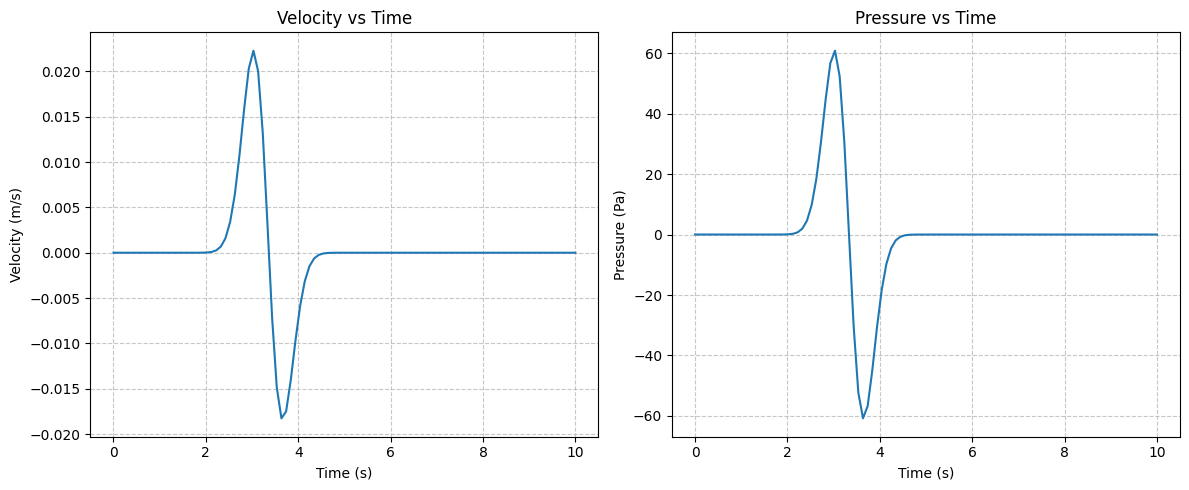

In [133]:
import numpy as np
import matplotlib.pyplot as plt

# Parameters
t = np.linspace(0, 10, 100)  # Time array from 0 to 10 seconds
r = 100  # Constant radius value
z = 0  # Constant z-value
c = 300  # Constant c-value

# Calculate velocity
velocity = test_velocity(t, r, z, c)[:,0]

# Calculate pressure (assuming a linear relationship for demonstration purposes)
pressure = test_pressure(t, r, z)

# Create a figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5), sharey=False)

# Plot velocity on the first subplot
ax1.plot(t, velocity)
ax1.set_xlabel('Time (s)')
ax1.set_ylabel('Velocity (m/s)')
ax1.set_title('Velocity vs Time')
ax1.grid(True, linestyle='--', alpha=0.7)

# Plot pressure on the second subplot
ax2.plot(t, pressure)
ax2.set_xlabel('Time (s)')
ax2.set_ylabel('Pressure (Pa)')
ax2.set_title('Pressure vs Time')
ax2.grid(True, linestyle='--', alpha=0.7)

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plot
plt.show()

In [134]:

N = 100
pressure_array = np.zeros((N, N))
x_low, x_upper = -800, 800
y_low, y_upper = -800, 800
times = np.linspace(0,10,100)

# Set up the figure and axis
fig, ax = plt.subplots()
im = ax.imshow(pressure_array, extent=[x_low, x_upper, y_low, y_upper], 
               aspect='auto', cmap='jet', origin='lower', vmin=-60, vmax=60)
plt.colorbar(im, label='Pressure (Pa)')
ax.set_xlabel('X (m)')
ax.set_ylabel('Y (m)')
ax.set_title('Pressure Distribution Over Time')

# Initialization function for animation
def init():
    im.set_array(np.zeros((N, N)))
    return [im]

# Animation update function
def update(t):
    for i in range(N):
        for j in range(N):
            x = x_low + (x_upper - x_low) * i / N
            y = y_low + (y_upper - y_low) * j / N

            pressure_array[j][i] = test_pressure(t, np.linalg.norm(np.array([x, y])), 0)

    im.set_array(pressure_array)
    ax.set_title(f'Pressure Distribution at t={t:.2f} s')
    return [im]

# Create animation
ani = FuncAnimation(fig, update, init_func=init, frames=times, 
                    interval=200)
plt.close()
HTML(ani.to_html5_video())

/var/folders/f7/g7y34v812n5_58yvtkt3mrw40000gn/T/ipykernel_28230/942386835.py:16: RuntimeWarning: divide by zero encountered in scalar divide
  return rho_0 * Q_dot(t - r_spherical/c) / (4 * np.pi * r_spherical)


## 2.0 Using test problem as input for Mario's surface integral

### Mario's solution for pressure 

$$
p'(x, t) = - \int_S n_i (\rho v_i v_j + p_{ij}) * \frac{\partial G}{\partial x_i} dS(\bar{x}') + \int_S n_i (\rho v_i) * \frac{\partial G}{\partial t} dS (\bar{x}')
$$

Where:
- $x$ is the receiver location.
- $x'$ is the source location.

### Monopole term 

$$
\int n_i (\rho v_i) \frac{\partial G}{\partial t} dS \equiv \sum_k \frac{1}{4\pi r_k} \frac{\partial}{\partial \tau} [(\rho(v \cdot n_k))]_{\tau_k} dS_k
$$

The retarded time derivative can be calculated by finite differences. 

### Dipole term 

$$
-\int n_i (\rho v_i v_j + P_{ij}) \frac{\partial G}{\partial x_i}dS \equiv - \frac{1}{4 \pi} \nabla_x \cdot \int_S \frac{F(x')}{r} dS(x')
$$

where 

$$
\vec{F} = \vec{n} \cdot (\rho \vec{v}\vec{v} + P)
$$

For the dipole term, we break the divergence into a finite difference approximation.

$$
\nabla \cdot U \equiv \sum_{i=1}^d \frac{U_i(x + \Delta x \vec{e}_i) - U_i(x - \Delta x \vec{e}_i)}{2 \Delta x}
$$

### Below lets apply our method to the test problem, and compare to the analytical results

In [ ]:
from helper_code.lighthill import compute_monopole_dipole_flux

N = 50  # number of points for integration
phi = np.linspace(0, 2 * np.pi, N)
theta = np.linspace(0, np.pi, N, endpoint=False)
times = np.linspace(0, 10, 100)

Theta, Phi = np.meshgrid(theta, phi, indexing="ij")

dphi = phi[1] - phi[0]
dtheta = theta[1] - theta[0]
a = 30  # radius of integration [m]

c0 = 300  # speed of sound [m/s]

dS = np.array(
    a**2 * np.sin(Theta) * dphi * dtheta
).flatten()  # differential area element on the sphere

normals = np.array(
    [
        np.sin(Theta.flatten()) * np.cos(Phi.flatten()),
        np.sin(Theta.flatten()) * np.sin(Phi.flatten()),
        np.cos(Theta.flatten()),
    ]
).T
x_prime = np.array(
    [
        np.cos(Phi.flatten()) * np.sin(Theta.flatten()) * a,
        np.sin(Phi.flatten()) * np.sin(Theta.flatten()) * a,
        np.cos(Theta.flatten()) * a,
    ]
).T

x_obs = np.array([200, 0, 0])

M_mom_dt = np.zeros((len(times)))
D_div = np.zeros((len(times)))
p_t = np.zeros((len(times)))

M_mom_dt_array = np.zeros((len(times), N**2))
D_div_array = np.zeros((len(times), N**2))

for i, t in enumerate(times):
    M_mom_dt[i], D_div[i], M_mom_dt_array[i], D_div_array[i] = (
        compute_monopole_dipole_flux(
            x_obs,
            t,
            x_prime,
            dS,
            normals,
            c0,
            times[-1],
            test_rho,
            test_velocity,
            test_sigma,
            dt=0.001,
            dx=0.001,
        )
    )

    if i % 20 == 0:
        print(f"Computing pressure at time {t} s")

Computing pressure at time 0.0 s
Computing pressure at time 2.0202020202020203 s
Computing pressure at time 4.040404040404041 s
Computing pressure at time 6.0606060606060606 s
Computing pressure at time 8.080808080808081 s


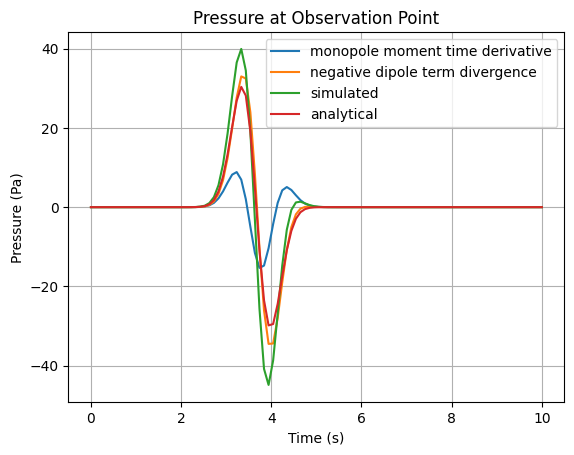

In [169]:

analytical_pressure = test_pressure(t=times, r=200, z=0)

plt.plot(times, M_mom_dt, label='monopole moment time derivative')
plt.plot(times, -D_div, label="negative dipole term divergence")
plt.plot(times, M_mom_dt - D_div, label="simulated")
plt.plot(times, analytical_pressure, label="analytical")
plt.plot()

plt.legend()

plt.xlabel("Time (s)")
plt.ylabel("Pressure (Pa)")
plt.title("Pressure at Observation Point")
plt.grid()
plt.show()

In [ ]:
from helper_code.animate import plot_surface_integral_contributions

ani = plot_surface_integral_contributions(M_mom_dt_array, "Monopole contribution", x_prime, normals, times, t_f=100, t_interval=2)
HTML(ani.to_html5_video())

In [173]:
from helper_code.animate import plot_surface_integral_contributions

ani = plot_surface_integral_contributions(D_div_array, "Dipole contribution", x_prime, normals, times, t_interval=2)
HTML(ani.to_html5_video())

## 2.1 Test problem with the source shifted up by 50m 


Let's again define

$$
\begin{align}
Q(t) &= \frac{1}{\sigma \sqrt(2 \pi)} e^{-\frac{1}{2} (\frac{t - \mu}{\sigma})^2} \\
\dot{Q}(t) &= - \frac{t-\mu}{\sigma^2} Q(t)
\end{align}
$$

But this time, let's set the (r, z) location of the source to be (0, 50).

We can see below plot, that below that both the pressure and velocity curves arrive at the point r=100, z=0 a little bit later when the source is at (0, 50) compared to (0, 0).


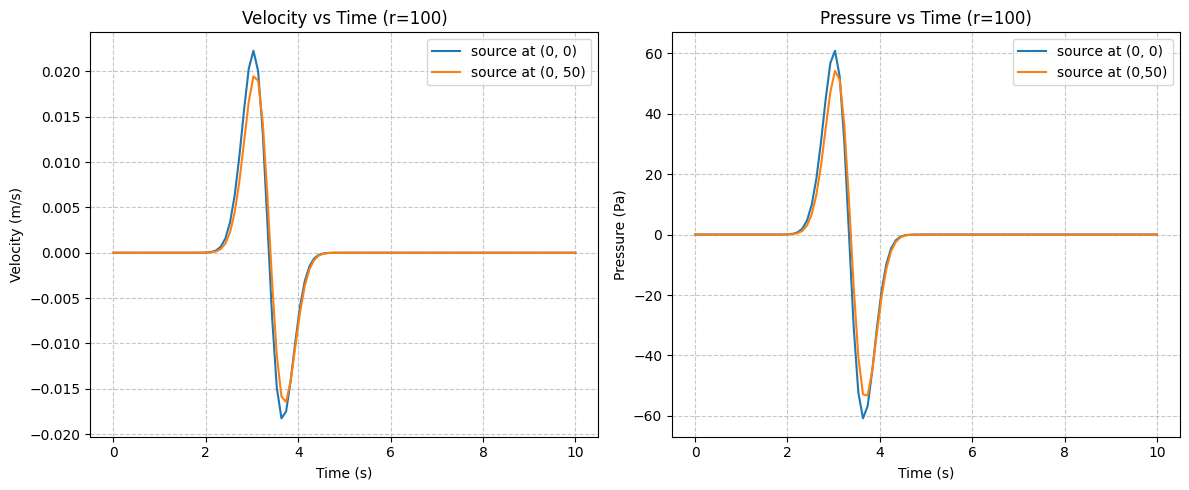

In [177]:
import numpy as np
import matplotlib.pyplot as plt

# Parameters
t = np.linspace(0, 10, 100)  # Time array from 0 to 10 seconds
r = 100  # Constant radius value
z = 0  # Constant z-value
c = 300  # Constant c-value

# Calculate velocity
velocity = test_velocity(t, r, z, c)[:,0]
velocity_shifted = test_velocity(t, r, z, c, z0=50)[:,0]

# Calculate pressure (assuming a linear relationship for demonstration purposes)
pressure = test_pressure(t, r, z)
pressure_shifted = test_pressure(t, r, z, c, z0=50)

# Create a figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5), sharey=False)

# Plot velocity on the first subplot
ax1.plot(t, velocity, label="source at (0, 0)")
ax1.plot(t, velocity_shifted, label="source at (0, 50)")
ax1.set_xlabel('Time (s)')
ax1.set_ylabel('Velocity (m/s)')
ax1.set_title(f'Velocity vs Time (r={r})')
ax1.grid(True, linestyle='--', alpha=0.7)
ax1.legend()

# Plot pressure on the second subplot
ax2.plot(t, pressure, label="source at (0, 0)")
ax2.plot(t, pressure_shifted, label="source at (0,50)")
ax2.set_xlabel('Time (s)')
ax2.set_ylabel('Pressure (Pa)')
ax2.set_title(f'Pressure vs Time (r={r})')
ax2.grid(True, linestyle='--', alpha=0.7)
ax2.legend()

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plot
plt.show()

In [182]:
def test_velocity_shifted_z(t, r, z, z0=50):
    return test_velocity(t, r, z, z0=z0)

def test_sigma_shifted_z(t, r, z, z0=50):
    return test_sigma(t, r, z, z0=z0)

M_mom_dt_shifted = np.zeros((len(times)))
D_div_shifted = np.zeros((len(times)))

M_mom_dt_array_shifted = np.zeros((len(times), N**2))
D_div_array_shifted = np.zeros((len(times), N**2))

a = 80  # radius of integration [m]
dS = np.array(
    a**2 * np.sin(Theta) * dphi * dtheta
).flatten()  # differential area element on the sphere

normals = np.array(
    [
        np.sin(Theta.flatten()) * np.cos(Phi.flatten()),
        np.sin(Theta.flatten()) * np.sin(Phi.flatten()),
        np.cos(Theta.flatten()),
    ]
).T
x_prime = np.array(
    [
        np.cos(Phi.flatten()) * np.sin(Theta.flatten()) * a,
        np.sin(Phi.flatten()) * np.sin(Theta.flatten()) * a,
        np.cos(Theta.flatten()) * a,
    ]
).T

for i, t in enumerate(times):
    M_mom_dt_shifted[i], D_div_shifted[i], M_mom_dt_array_shifted[i], D_div_array_shifted[i] = compute_monopole_dipole_flux(x_obs, t, x_prime, dS, normals, c0, times[-1], test_rho, test_velocity_shifted_z, test_sigma_shifted_z)

    if i % 20 == 0:
        print(f"Computing pressure at time {t} s")

Computing pressure at time 0.0 s
Computing pressure at time 2.0202020202020203 s
Computing pressure at time 4.040404040404041 s
Computing pressure at time 6.0606060606060606 s
Computing pressure at time 8.080808080808081 s


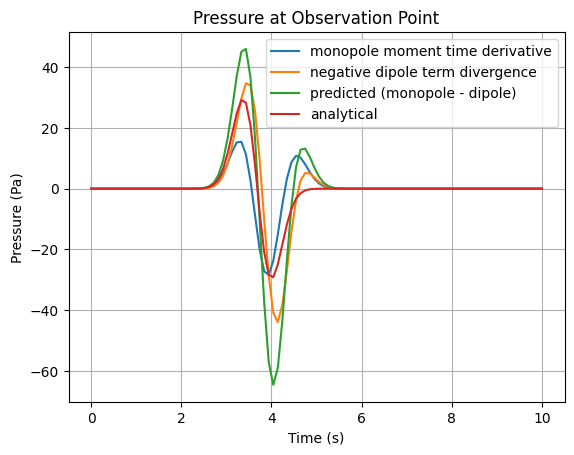

In [186]:
analytical_pressure = test_pressure(t=times, r=200, z=0, z0=50)

plt.plot(times, M_mom_dt_shifted, label='monopole moment time derivative')
plt.plot(times, -D_div_shifted, label="negative dipole term divergence")
plt.plot(times, (M_mom_dt_shifted - D_div_shifted), label='predicted (monopole - dipole)')
plt.plot(times, analytical_pressure, label="analytical")
plt.plot()

plt.legend()

plt.xlabel("Time (s)")
plt.ylabel("Pressure (Pa)")
plt.title("Pressure at Observation Point")
plt.grid()
plt.show()

In [180]:
from helper_code.animate import plot_surface_integral_contributions

ani = plot_surface_integral_contributions(M_mom_dt_array_shifted, "Monopole contribution", x_prime, normals, times, t_f=100, t_interval=2)
HTML(ani.to_html5_video())

In [181]:
from helper_code.animate import plot_surface_integral_contributions

ani = plot_surface_integral_contributions(D_div_array_shifted, "Dipole contribution", x_prime, normals, times, t_interval=2)
HTML(ani.to_html5_video())

## 3.0 Applying the same method to Fred's data



In [187]:
import os

os.chdir("/Users/paxton/git/volcano_sims/fred_data")

print(os.getcwd())
print(os.listdir())

# Load compressed npz archive
# The archive contains the field "time" and "state_coeffs"
#   archive["time"] is an np.array with size (n_timesteps)
#   archive["state_coeffs"] is an np.array with size (n_timesteps, n_elems, n_basis, n_states)
# The field "state_coeffs" contains the solver.state_coeffs variables for all
# the output files, combined into one array.

# Example below (loading multiple at a time may use a lot of memory):
archive = np.load(f"refblastH4_atm1.npz")

/Users/paxton/git/volcano_sims/fred_data
['refblastH4_atm2_0.pkl', 'refblastH4_atm1.npz', 'test_data.npz', 'refblastH4_atm2.npz', 'refblastH4_atm3.npz', 'refblastH4_atm1_0.pkl', 'refblastH4_atm3_0.pkl']


In [68]:
import helper_code.lighthill as lighthill
import numpy as np
import matplotlib.tri as tri

def solver_from_2D(dom, i):
    solver_func = get_local_solver_from_index_func("fred_data", f"refblastH4_atm{dom}")

    return solver_func(i)

# Prep interpolation grid
solver0 = solver_from_2D(1, 0)
physics = solver0.physics
base_x = np.linspace(0, 300, 200)
base_y = np.linspace(-125, 300, 200)
mg_x, mg_y = np.meshgrid(base_x, base_y, indexing="xy")

solver0_list = [solver_from_2D(dom_idx, 0) for dom_idx in [1]]
# Compute workload partition
ind_partition = [np.where(tri.Triangulation(
  solver.mesh.node_coords[...,0],
  solver.mesh.node_coords[...,1], 
  triangles=solver.mesh.elem_to_node_IDs).get_trifinder()(mg_x.ravel(), mg_y.ravel()) != -1)[0]
  for solver in solver0_list]

# List of file indices to read
file_index_list = np.arange(0,archive["time"].shape[0]//6,4)

print(file_index_list.size)

150


In [6]:
# Allocate union (joining all times) U, in spatially-flattened shape
U_union = np.nan * np.empty((file_index_list.size, *mg_x.ravel().shape, 8+physics.NDIMS))

for time_idx, file_idx in enumerate(file_index_list):

	# Load solvers for given time_idx
	solver_list = [solver_from_2D(dom_idx, 0) for dom_idx in [1]]

	for solver, _index_partition in zip(solver_list, ind_partition):
		# Identify physical position (x, y) of points to interpolate at with shape (npoints, 2)
		_phys_pos = np.stack(
			(mg_x.ravel()[_index_partition],
			mg_y.ravel()[_index_partition]),
			axis=1)
		# Identify element indices for all points to interpolate at
		elt_indices = tri.Triangulation(
			solver.mesh.node_coords[...,0],
			solver.mesh.node_coords[...,1], 
			triangles=solver.mesh.elem_to_node_IDs).get_trifinder()(_phys_pos[:,0], _phys_pos[:,1])

		# Identify element node coordinates
		x_tri = solver.mesh.node_coords[solver.mesh.elem_to_node_IDs]
		# Compute global physical-to-reference coordinate mapping
		ref_mapping = lighthill.compute_ref_mapping(x_tri)

		state_coeffs = archive["state_coeffs"][file_idx, ...]

		# Interpolate for each point using the correct element, writing to correct index in global U array
		for (write_idx, x_point, ie) in zip(_index_partition, _phys_pos, elt_indices):
			# For element containing point, compute reference coordinate of sampling point
			ref_coords_loc = np.einsum("ij, j -> i",
																ref_mapping[ie,...],
																x_point - x_tri[ie,0,:])
			# Evaluate basis at reference coordinate
			#U_union[time_idx,write_idx,:] = (solver.state_coeffs[ie,0,:] * (1 - ref_coords_loc[0] - ref_coords_loc[1]))

            # I believe this is the correct calculation for order 1
			U_union[time_idx,write_idx,:] = (state_coeffs[ie,0,:] * (1 - ref_coords_loc[0] - ref_coords_loc[1]) + state_coeffs[ie,1,:] * ref_coords_loc[0] + state_coeffs[ie,2,:] * ref_coords_loc[1])

In [7]:
# Evaluate temperature using interpolated state, migrate to meshgrid shape (time_indices, mg_x.shape[0], mg_x.shape[1])
T_interp = np.reshape(physics.compute_variable("Temperature", U_union).squeeze(axis=2), (file_index_list.size, *mg_x.shape))
rho = U_union[...,0:3].sum(axis=-1, keepdims=True)
yM = np.reshape(U_union[...,2:3] / rho, (file_index_list.size, *mg_x.shape))

t_range = np.linspace(0, archive["time"].max(), archive["time"].shape[0])

In [8]:
rho = U_union[...,0:3].sum(axis=-1, keepdims=True)
u = U_union[:,:,3:4] / rho
v = U_union[:,:,4:5] / rho

# Pull rho, u, v
mg_u = np.reshape(u, (file_index_list.size, *mg_x.shape))
mg_v = np.reshape(v, (file_index_list.size, *mg_x.shape))
mg_T = np.reshape(physics.compute_variable("Temperature", U_union).squeeze(axis=2), (file_index_list.size, *mg_x.shape))
mg_p = np.reshape(physics.compute_variable("Pressure", U_union).squeeze(axis=2), (file_index_list.size, *mg_x.shape))
mg_rho = np.reshape(rho, (file_index_list.size, *mg_x.shape))
mg_c = np.reshape(physics.compute_variable("SoundSpeed", U_union).squeeze(axis=2), (file_index_list.size, *mg_x.shape))
mg_p0 = mg_p[0,...]

In [9]:
v_data = np.stack((mg_u, mg_v), axis=-1)

mg_sigma = np.zeros((*mg_p.shape, 3, 3))

mg_sigma[:,:,:,0,0] = -mg_p
mg_sigma[:,:,:,1,1] = -mg_p
mg_sigma[:,:,:,2,2] = -mg_p

In [32]:
from scipy.interpolate import RegularGridInterpolator
points_ = (t_range[file_index_list], mg_y[:,0], mg_x[0,:])

def get_rho(t, r, z, rho_data=mg_rho, points=points_):
    rho_interpolator = RegularGridInterpolator(points, rho_data, method='linear', bounds_error=False, fill_value=0)

    return np.nan_to_num(rho_interpolator([t, z, r]))


def get_v(t, r, z, v_data=v_data, points=points_):
    v_interpolator = RegularGridInterpolator(points, v_data, method='linear', bounds_error=False, fill_value=0)

    return np.nan_to_num(v_interpolator([t, z, r])).reshape((2))


def get_sigma(t, r, z, sigma_data=mg_sigma, points=points_):
    sigma_interpolator = RegularGridInterpolator(points, sigma_data, method='linear', bounds_error=False, fill_value=0)

    return np.nan_to_num(sigma_interpolator([t, z, r])).reshape((3,3))


/var/folders/f7/g7y34v812n5_58yvtkt3mrw40000gn/T/ipykernel_28230/2732481439.py:4: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  v_test[i, j] = get_rho(5, mg_x[0,j], mg_y[i,0])


Text(0, 0.5, 'z')

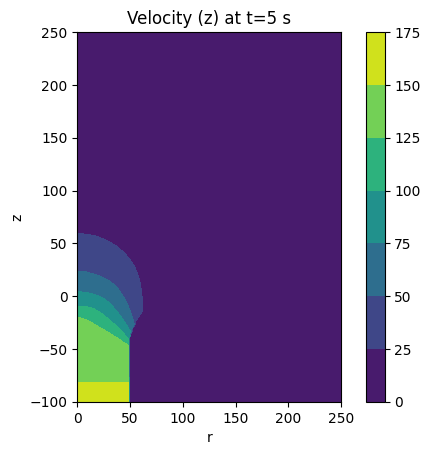

In [33]:
v_test = np.zeros(mg_x.shape)
for i in range(v_test.shape[0]):
    for j in range(v_test.shape[1]):
        v_test[i, j] = get_rho(5, mg_x[0,j], mg_y[i,0])

plt.contourf(mg_x, mg_y, v_test)
plt.xlim(0, 250)
plt.ylim(-100, 250)
plt.gca().set_aspect('equal')  # Set equal aspect ratio
plt.colorbar()
plt.title(f"Velocity (z) at t={5} s")
plt.xlabel("r")
plt.ylabel("z")

In [ ]:
from helper_code.lighthill import compute_monopole_dipole_flux

N = 20  # number of points for integration
phi = np.linspace(0, 2 * np.pi, N)
theta = np.linspace(0, 4 * np.pi / 6, N, endpoint=False)

Theta, Phi = np.meshgrid(theta, phi, indexing="ij")

dphi = phi[1] - phi[0]
dtheta = theta[1] - theta[0]
a = 150  # radius of integration [m]

c0 = 320  # speed of sound [m/s]
t_f = t_range[file_index_list[-1]]

dS = np.array(
    a**2 * np.sin(Theta) * dphi * dtheta
).flatten()  # differential area element on the sphere

normals = np.array(
    [
        np.sin(Theta.flatten()) * np.cos(Phi.flatten()),
        np.sin(Theta.flatten()) * np.sin(Phi.flatten()),
        np.cos(Theta.flatten()),
    ]
).T
x_prime = np.array(
    [
        np.cos(Phi.flatten()) * np.sin(Theta.flatten()) * a,
        np.sin(Phi.flatten()) * np.sin(Theta.flatten()) * a,
        np.cos(Theta.flatten()) * a,
    ]
).T

x_obs = np.array([200, 0, 0])

points_ = (t_range[file_index_list], mg_y[:, 0], mg_x[0, :])

M_mom_dt_fred = np.zeros((len(t_range[file_index_list])))
D_div_fred = np.zeros((len(t_range[file_index_list])))

M_mom_dt_array_fred = np.zeros((len(t_range[file_index_list]), N**2))
D_div_array_fred = np.zeros((len(t_range[file_index_list]), N**2))


for i, t in enumerate(t_range[file_index_list]):
    M_mom_dt_fred[i], D_div_fred[i], M_mom_dt_array_fred[i], D_div_array_fred[i] = (
        compute_monopole_dipole_flux(
            x_obs, t, x_prime, dS, normals, c0, t_f, get_rho, get_v, get_sigma, dt=0.2, dx=1,
        )
    )

    if i % 20 == 0:
        print(f"Computing pressure at time {t} s")

Computing pressure at time 0.0 s
Computing pressure at time 1.3333333333244832 s
Computing pressure at time 2.6666666666489665 s
Computing pressure at time 3.9999999999734497 s
Computing pressure at time 5.333333333297933 s
Computing pressure at time 6.666666666622416 s
Computing pressure at time 7.999999999946899 s
Computing pressure at time 9.333333333271382 s


133
59


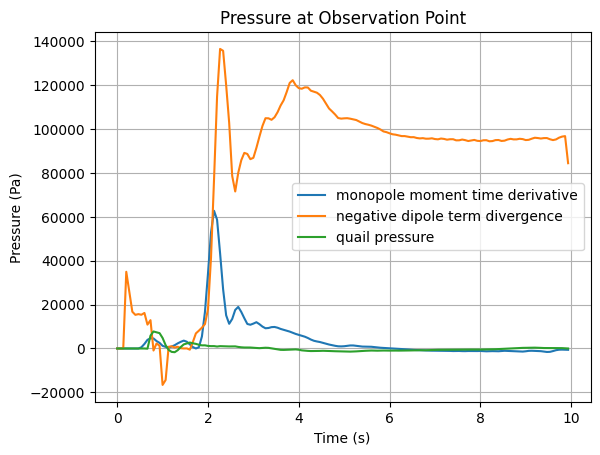

In [208]:
x_idx = np.argmin(np.abs(mg_x[0,:] - 200))
y_idx = np.argmin(np.abs(mg_y[:,0] - 0))

print(x_idx)
print(y_idx)

delta_p_quail = mg_p[:, y_idx, x_idx] - mg_p[0,y_idx, x_idx]

plt.plot(t_range[file_index_list], M_mom_dt_fred, label='monopole moment time derivative')
plt.plot(t_range[file_index_list], -D_div_fred, label="negative dipole term divergence")
plt.plot(t_range[file_index_list], delta_p_quail, label='quail pressure')

plt.legend()

plt.xlabel("Time (s)")
plt.ylabel("Pressure (Pa)")
plt.title("Pressure at Observation Point")
plt.grid()
plt.show()

In [199]:
from helper_code.animate import plot_surface_integral_contributions

ani = plot_surface_integral_contributions(M_mom_dt_array_fred, "Monopole contribution", x_prime, normals, t_range[file_index_list], t_f=150, t_interval=2)
HTML(ani.to_html5_video())

In [200]:
from helper_code.animate import plot_surface_integral_contributions

ani = plot_surface_integral_contributions(D_div_array_fred, "Dipole contribution", x_prime, normals, t_range[file_index_list], t_f=150, t_interval=2)
HTML(ani.to_html5_video())